In [1]:

%pprint

Pretty printing has been turned OFF



---
# Load needed libraries and functions

In [2]:

%matplotlib inline
from datetime import datetime
from pandas import DataFrame
import humanize
import os
import sys
import time
import warnings
import winsound

warnings.filterwarnings('ignore')
duration = 1000  # milliseconds
freq = 880  # Hz

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

# Get the Neo4j driver
from storage import Storage
s = Storage(
    data_folder_path=os.path.abspath('../data'),
    saves_folder_path=os.path.abspath('../saves')
)

from ha_utils import HeaderAnalysis
ha = HeaderAnalysis(s=s, verbose=False)

from scrape_utils import WebScrapingUtilities
wsu = WebScrapingUtilities(
    s=s,
    secrets_json_path=os.path.abspath('../data/secrets/jh_secrets.json')
)
uri = wsu.secrets_json['neo4j']['connect_url']
user =  wsu.secrets_json['neo4j']['username']
password = wsu.secrets_json['neo4j']['password']

# Get the neo4j object
from cypher_utils import CypherUtilities
cu = CypherUtilities(
    uri=uri, user=user, password=password, driver=None, s=s, ha=ha
)


---
# Visualize Interview Progress

In [4]:

cypher_str = '''
    // Find all FileNames nodes in the graph with progress dates
    MATCH (fn:FileNames)
    WHERE (fn.opportunity_application_email_date IS NOT NULL)
    
    // Return the progress dates, including the last technical interview date
    RETURN
        fn.opportunity_application_email_date AS opportunity_application_email_date,
        fn.recruiter_screen_date AS recruiter_screen_date,
        fn.technical_interview_dates[-1] AS technical_interview_date,
        fn.rejection_email_date AS rejection_email_date
    
    // Sort the results by successive progress dates
    ORDER BY
        fn.opportunity_application_email_date,
        fn.recruiter_screen_date,
        fn.technical_interview_dates[-1],
        fn.rejection_email_date;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    progress_dates_df = DataFrame(row_objs_list)

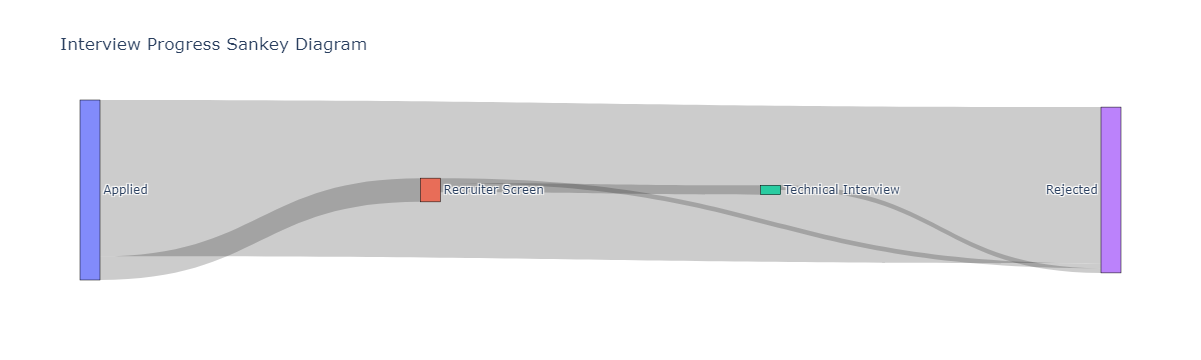

In [30]:

import plotly.graph_objects as go

# Define the nodes of the Sankey diagram
mask_series = progress_dates_df.recruiter_screen_date.isnull()
start_date = progress_dates_df[~mask_series].opportunity_application_email_date.min()
mask_series = (progress_dates_df.opportunity_application_email_date >= start_date)
df = progress_dates_df[mask_series]

labels_list = ['Applied', 'Recruiter Screen', 'Technical Interview', 'Rejected']
title_str = 'Interview Progress Sankey Diagram'
fig = go.Figure(data=[go.Sankey(
    arrangement='fixed',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels_list,
        y=[
            
            # Applied (node 0)
            0.0,

            # Recruiter Screen (node 1)
            0.333,

            # Technical Interview (node 2)
            0.667,

            # Rejected (node 3)
            1.0,
        
        ],
    ),
    link=dict(
        source=[
            
            # Link from Applied (node 0) to Recruiter Screen (node 1)
            labels_list.index('Applied'),

            # Link from Applied (node 0) to Rejected (node 3)
            labels_list.index('Applied'),

            # Link from Recruiter Screen (node 1) to Technical Interview (node 2)
            labels_list.index('Recruiter Screen'),

            # Link from Recruiter Screen (node 1) to Rejected (node 3)
            labels_list.index('Recruiter Screen'),

            # Link from Technical Interview (node 2) to Rejected (node 3)
            labels_list.index('Technical Interview'),
            
        ],
        target=[
            
            # Link from Applied (node 0) to Recruiter Screen (node 1)
            labels_list.index('Recruiter Screen'),

            # Link from Applied (node 0) to Rejected (node 3)
            labels_list.index('Rejected'),

            # Link from Recruiter Screen (node 1) to Technical Interview (node 2)
            labels_list.index('Technical Interview'),

            # Link from Recruiter Screen (node 1) to Rejected (node 3)
            labels_list.index('Rejected'),

            # Link from Technical Interview (node 2) to Rejected (node 3)
            labels_list.index('Rejected'),
            
        ],
        value=[
            
            # Applied to Recruiter Screen flow
            df[~df.opportunity_application_email_date.isnull() & ~df.recruiter_screen_date.isnull()].shape[0],

            # Applied to Rejected flow
            df[~df.opportunity_application_email_date.isna()&df.recruiter_screen_date.isna()&df.technical_interview_date.isnull()&~df.rejection_email_date.isna()].shape[0],

            # Recruiter Screen to Technical Interview flow
            df[~df.recruiter_screen_date.isnull() & ~df.technical_interview_date.isnull()].shape[0],

            # Recruiter Screen to Rejected flow
            df[~df.recruiter_screen_date.isnull() & df.technical_interview_date.isnull() & ~df.rejection_email_date.isnull()].shape[0],

            # Technical Interview to Rejected flow
            df[~df.technical_interview_date.isnull() & ~df.rejection_email_date.isnull()].shape[0],
            
        ]
    )
)])

fig.update_layout(title_text=title_str)
fig.show()


---
# Visualize Daily Application Count

In [33]:

cypher_str = '''
    // Find all FileNames nodes in the graph and filter out any nodes where a cover letter hasn't been mailed
    MATCH (fn:FileNames)
    WHERE
        (fn.is_opportunity_application_emailed = true)
        AND (fn.opportunity_application_email_date IS NOT NULL)
    
    // Return the email date and fitness
    WITH fn, date(fn.opportunity_application_email_date) AS email_date
    RETURN email_date, fn.percent_fit AS percent_fit
    
    // Sort the results by email date
    ORDER BY email_date;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    email_dates_df = DataFrame(row_objs_list)

In [34]:

from datetime import date, datetime

def get_int_from_date(date_obj):
    time_struct = date_obj.timetuple()
    datetime_obj = datetime(year=time_struct.tm_year, month=time_struct.tm_mon, day=time_struct.tm_mday)
    
    return int(datetime_obj.timestamp())

I'm averaging 3.29 job applications per day this week.


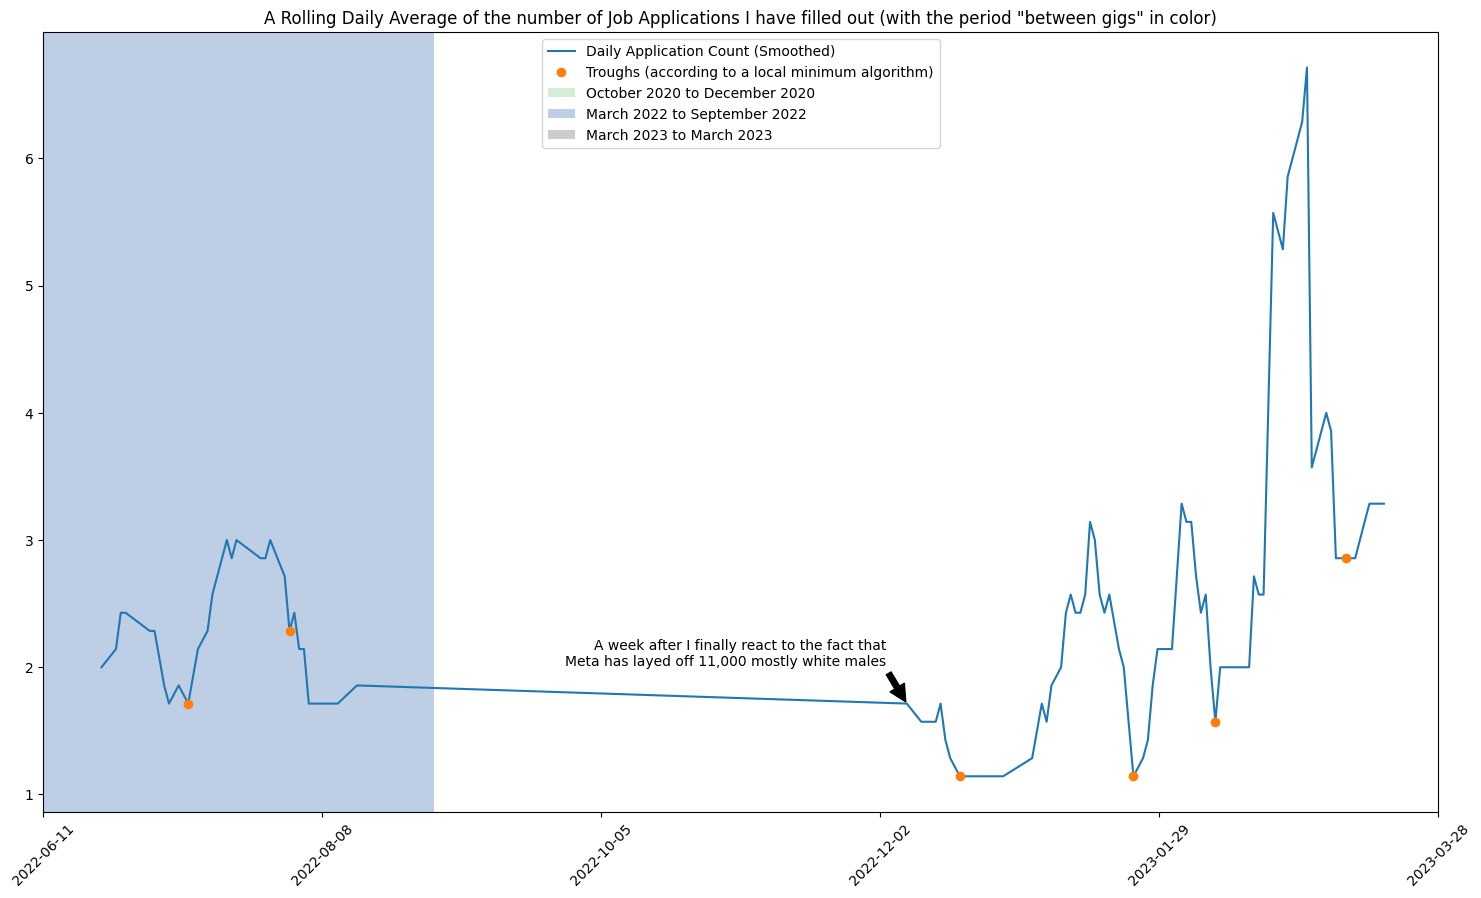

In [39]:

import numpy as np
import peakutils
import matplotlib.pyplot as plt
from matplotlib.text import Text
from cycler import cycler

# Generate line plot data by converting dates to ints and back
df = email_dates_df.groupby('email_date').count().rename(columns={'percent_fit': 'daily_applications'}).rolling(7).mean().dropna()
print(f"I'm averaging {df.iloc[-1].squeeze():.3} job applications per day this week.")
x = df.index.map(lambda date_obj: get_int_from_date(date_obj))
y = df.daily_applications

# # Detect the troughs in the negated data
trough_indices = peakutils.indexes(-y, thres=0.5, min_dist=10)

# # Fit a Gaussian model to the troughs
trough_props = peakutils.interpolate(x, y, trough_indices)

# Plot the data and the troughs
fig, ax = plt.subplots(figsize=(18, 18*9/16))
ax.set_xlim(left=get_int_from_date(df.index.min()), right=get_int_from_date(df.index.max()))
ax.set_title('A Rolling Daily Average of the number of Job Applications I have filled out (with the period "between gigs" in color)')
ax.plot(x, y, label='Daily Application Count (Smoothed)')
ax.plot(x[trough_indices], y[trough_indices], 'o', label='Troughs (according to a local minimum algorithm)')

# Mark the periods of unemployment
cycler = cycler('color', plt.cm.Accent(np.linspace(0, 1, 3)))
for date_range_str, face_color_dict in zip(['October 2020 to December 2020', 'March 2022 to September 2022', 'March 2023 to March 2023'], cycler()):
    face_color = face_color_dict['color']
    date_range_list = date_range_str.split(' to ')
    ax.axvspan(get_int_from_date(datetime.strptime(date_range_list[0], '%B %Y')),
               get_int_from_date(datetime.strptime(date_range_list[1], '%B %Y')),
               facecolor=face_color, alpha=0.33, label=date_range_str)

# Annotate layoffs
date_str = 'November 9, 2022'
date_obj = datetime.strptime(date_str, '%B %d, %Y').date()
df['nearest_layoff'] = df.index.map(lambda email_date: abs((date_obj - email_date.to_native()).days))
mask_series = (df.nearest_layoff == df.nearest_layoff.min())
ax.annotate('A week after I finally react to the fact that\nMeta has layed off 11,000 mostly white males',
            xy=(df[mask_series].index.map(lambda date_obj: get_int_from_date(date_obj))[0], df[mask_series].daily_applications.squeeze()), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

# Reconfigure the x axis labels so that they are dates again
xtick_positions = ax.get_xticks(minor=False)
xtick_labels = [Text(ts, 0, datetime.fromtimestamp(ts).strftime('%Y-%m-%d')) for ts in xtick_positions]
ax.set_xticks(xtick_positions, xtick_labels, rotation=45)

ax.legend()
plt.show()

I'm averaging 3.29 job applications per day this week.


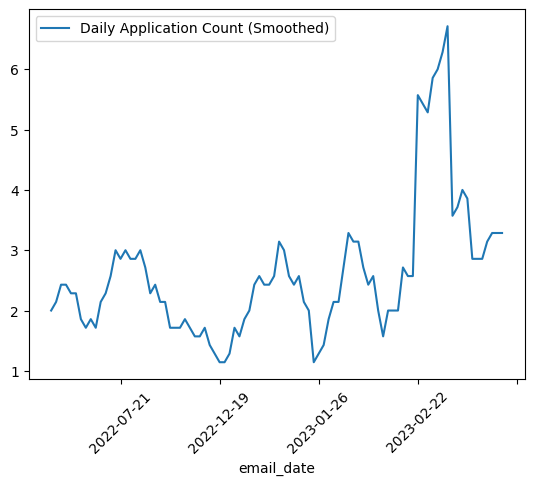

In [41]:

df = email_dates_df.groupby('email_date').count().rename(columns={'percent_fit': 'Daily Application Count (Smoothed)'}).rolling(7).mean()
print(f"I'm averaging {df.iloc[-1].squeeze():.3} job applications per day this week.")
fig, ax = plt.subplots()
df.plot(kind='line', rot=45, ax=ax);

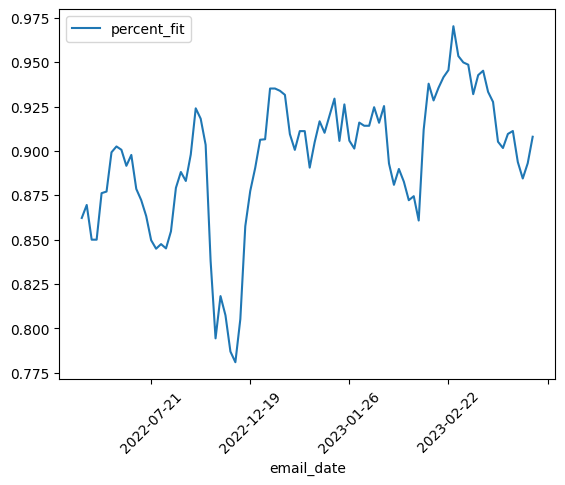

In [40]:

df = email_dates_df.groupby('email_date').mean().rolling(7).mean()
df.plot(kind='line', rot=45);


---
# Visualize Accenture Job Titles

In [5]:

def do_cypher_tx(tx, verbose=False):
    cypher_str = """
        // Get all the information related to job titles
        MATCH (fn:FileNames)
        WHERE (fn.role_title IS NOT NULL)
        RETURN fn;"""
    if verbose:
        clear_output(wait=True)
        print(cypher_str)
    parameter_dict = {}
    rows_list = []
    for record in tx.run(query=cypher_str, parameters=parameter_dict):
        row_dict = {k: v for k, v in dict(record.items())['fn'].items()}
        rows_list.append(row_dict)
    from pandas import DataFrame
    df = DataFrame(rows_list)

    return df
verbose = False
with cu.driver.session() as session:
    df = session.write_transaction(do_cypher_tx, verbose=verbose)
    if verbose:
        print(df.to_dict('records'))

['Data Scientist', 'Super Pod QA Lead', 'Data Designer', 'Data Engineer', 'Splunk Data Engineering PM', 'Splunk Developer', 'Splunk Senior Developer', 'Full Stack Developer']


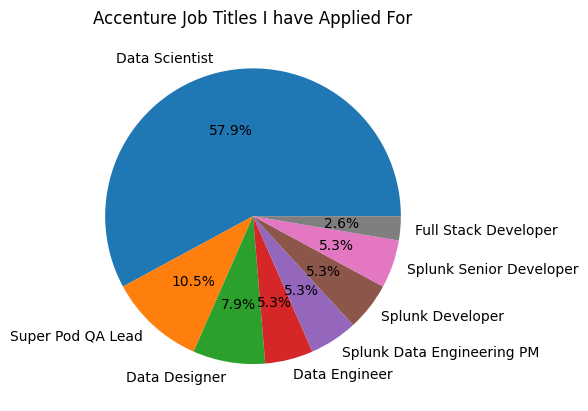

In [35]:

import re
import matplotlib.pyplot as plt

df['job_title'] = df.role_title.map(lambda x: re.sub(r' Copy\b', '', re.sub(r'[0-9\-_]+', ' ', str(x)).split('(')[0]).strip())
mask_series = (df.percent_fit >= 0.8)
job_series = df[mask_series].groupby('job_title').count().sort_values('percent_fit', ascending=False).percent_fit
print(job_series.head(10).index.tolist())

# Create a pie chart
plt.pie(job_series.values, labels=job_series.index, autopct='%1.1f%%')
plt.title('Accenture Job Titles I have Applied For')

# Display the chart
plt.show()

In [32]:

df.columns

Index(['assigned_role', 'career_level_from_to', 'file_name',
       'role_primary_contact_email_id', 'is_role_sold', 'role_title',
       'role_client_supply_contact', 'role_id', 'project_metro_city',
       'role_end_date', 'percent_fit', 'role_primary_contact',
       'role_start_date', 'client_name', 'is_verified',
       'is_opportunity_application_emailed',
       'opportunity_application_email_date', 'rejection_email_text',
       'is_closed', 'rejection_email_date', 'job_title'],
      dtype='object')

In [34]:

mask_series = df.job_title.map(lambda x: 'Data Scientist' in x)
columns_list = ['percent_fit', 'assigned_role', 'role_title', 'opportunity_application_email_date', 'file_name']
df[mask_series][columns_list].sort_values('percent_fit')

,percent_fit,assigned_role,role_title,opportunity_application_email_date,file_name
1185,0.166667,Data Science Practitioner,Data Scientist,NaN,4698820_META_PLATFORMS_INC_Data_Scientist.html
3119,0.333333,Data Science Practitioner,Data Scientist,NaN,4698820_0_META_PLATFORMS_INC_Data_Scientist.html
72,1.000000,Business Analyst,62812-439400_Data Scientist(priya.raman),2023-02-22,4656009_Accenture_CIO_62812_439400_Data_Scient...
2032,1.000000,Business Analyst,62812-439276_Data Scientist(priya.raman),2023-02-22,4656042_0_Accenture_CIO_62812_439276_Data_Scie...
2031,1.000000,Business Analyst,62812-439275_Data Scientist(priya.raman),2023-02-22,4656041_0_Accenture_CIO_62812_439275_Data_Scie...
2030,1.000000,Business Analyst,62812-439274_Data Scientist(priya.raman),2023-02-22,4656040_0_Accenture_CIO_62812_439274_Data_Scie...
2029,1.000000,Business Analyst,62812-439271_Data Scientist(priya.raman),2023-02-22,4656039_0_Accenture_CIO_62812_439271_Data_Scie...
2020,1.000000,Business Analyst,62812-439416_Data Scientist(priya.raman),2023-02-22,4656014_0_Accenture_CIO_62812_439416_Data_Scie...
2019,1.000000,Business Analyst,62812-439415_Data Scientist(priya.raman),2023-02-22,4656013_0_Accenture_CIO_62812_439415_Data_Scie...
2018,1.000000,Business Analyst,62812-439414_Data Scientist(priya.raman),2023-02-22,4656012_0_Accenture_CIO_62812_439414_Data_Scie...



----

In [ ]:

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Create a plot with xkcd style
with plt.xkcd():
    fig, ax = plt.subplots()
    ax.set_xlabel('Physical Therapy')
    ax.set_ylabel('Power Lifting')
    ax.set_title('Where Strength Training Lies')
    
    # Create a triangular-shaped path
    x = [0.2, 0.8, 0.2, 0.2]
    y = [0.2, 0.2, 0.8, 0.2]
    path = plt.Polygon(list(zip(x, y)))
    
    # Create a plot and fill the path with a color
    ax.add_patch(path)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.fill(x, y, 'lightblue')
    
    plt.show()